# Coursera: Battle of Neighborhoods 

This notebook is part of IBM Applied Data Science Capstone project

I am interested in exploring schools in Sweden. In this notebook I will attempt to scrape school names and addresses from edarabia, request their coordinates, and explore the area with Foursquare API.

In [ ]:
# get drivers ready for selenium scraping
from zipfile import ZipFile
import wget

wget.download('https://github.com/mozilla/geckodriver/releases/download/v0.27.0/geckodriver-v0.27.0-win64.zip', 'gecko.zip')
with ZipFile('gecko.zip', 'r') as z: z.extractall('.')

# Note: the file had been downloaded from previous project
# so I did not run this code.

In [16]:
# scrape https://www.edarabia.com/schools/sweden/ for Sweden top schools.
from selenium import webdriver

driver = webdriver.Firefox(executable_path='geckodriver.exe')
driver.get('https://www.edarabia.com/schools/sweden/')

In [12]:
# Upon inspection, school names are part of a hyperlink under <h5> tags
links = driver.find_elements_by_xpath('//h5/a')
for i, link in enumerate(links):
    print(i, link.text)

0 
1 
2 
3 
4 Bladins International School
5 Deutsche Schule Stockholm
6 Engelska Skolan Norr AB
7 Fryshuset School
8 International IT College of Sweden
9 Lycee Francais Saint Louis in Stockholm
10 ProCivitas Private Gymnasium Stockholm
11 Swedish Finnish School
12 The Tanto International School
13 Thea Private Grundskola


In [14]:
# there seem to be empty links, lets remove them
schools = [link.text for link in links if link.text]
schools

['Bladins International School',
 'Deutsche Schule Stockholm',
 'Engelska Skolan Norr AB',
 'Fryshuset School',
 'International IT College of Sweden',
 'Lycee Francais Saint Louis in Stockholm',
 'ProCivitas Private Gymnasium Stockholm',
 'Swedish Finnish School',
 'The Tanto International School',
 'Thea Private Grundskola']

In [17]:
# Let's see if we can get their address.
address = driver.find_elements_by_xpath('//ul/li')
for i, addr in enumerate(address):
    print(i, addr.text)

0 
1 Universities
2 Schools
3 Nurseries
4 Courses
5 Jobs
6 Events
7 Login
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 Home
56 Schools
57 Sweden
58 Preschool (förskola)
59 Compulsory schooling which is made up of Elementary school (lågstadiet), middle school (mellanstadiet) and junior high school (högstadiet).
60 Upper secondary school or senior high school (gymnasium)
61 Tertiary education
62 
63 
64 
65 
66 
67 
68 
69 
70 
71 
72 
73 
74 
75 Address: Sjallandstorget 1
76 Curriculum: IB
77 SEK 23,500
78 Address: Karlavagen 25
79 Address: Roslagstullsbacken 4
80 Founded: 1993
81 Address: Martensdalsgatan 2-8
82 Founded: 1984
83 Address: Halsobrunnsgatan 6
84 Founded: 2003
85 Address: Essingestraket 24
86 Founded: 1959
87 Curriculum: French
88 SEK 12,375
89 Address: Sandbacksgatan 10
90 Address: Ryttargatan 275, Planner
91 Address: Flintbacken 

In [ ]:
# That should be all the data needed so let's close the driver
driver.close()

In [25]:
# We can isolate the address by looking for string "Address:"
school_addresses = []
for addr in address:
    addr = addr.text
    if "Address:" in addr:
        addr.replace('Address: ', '')
        # The ", Planner" in 1 of the addresses is causing problem with geolocation
        # so I remove it
        addr = addr.split(',')[0]
        school_addresses.append(addr.replace('Address: ', ''))
school_addresses


['Sjallandstorget 1',
 'Karlavagen 25',
 'Roslagstullsbacken 4',
 'Martensdalsgatan 2-8',
 'Halsobrunnsgatan 6',
 'Essingestraket 24',
 'Sandbacksgatan 10',
 'Ryttargatan 275',
 'Flintbacken 20',
 'Tullgardsgatan 10']

In [26]:
# check if we get same number of addresses and schools
print(len(schools))
print(len(school_addresses))

10
10


In [28]:
# see if we can get coordinates from address
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='my_agent')
lat = []
long = []
for addr in school_addresses:
    loc = geolocator.geocode(f'{addr}, Sweden')
    lat.append(loc.latitude)
    long.append(loc.longitude)


In [31]:
# check leng of lat and long
print(len(lat))
print(len(long))

10
10


In [33]:
# All lists contain same number of elements
# We can zip them and create dataframe
import pandas as pd

df = pd.DataFrame(zip(schools, school_addresses, lat, long), columns=['School','Address','Lat','Long'])

,School,Address,Lat,Long
0,Bladins International School,Sjallandstorget 1,55.592730,12.987777
1,Deutsche Schule Stockholm,Karlavagen 25,59.345046,18.063079
2,Engelska Skolan Norr AB,Roslagstullsbacken 4,59.350678,18.059369
3,Fryshuset School,Martensdalsgatan 2-8,59.300544,18.088212
4,International IT College of Sweden,Halsobrunnsgatan 6,59.337121,18.047313
5,Lycee Francais Saint Louis in Stockholm,Essingestraket 24,59.319225,17.989403
6,ProCivitas Private Gymnasium Stockholm,Sandbacksgatan 10,59.316701,18.080628
7,Swedish Finnish School,Ryttargatan 275,59.507273,17.907965
8,The Tanto International School,Flintbacken 20,59.309693,18.049634
9,Thea Private Grundskola,Tullgardsgatan 10,59.305603,18.084816


In [10]:
# let's see if we can get the city name
import reverse_geocoder as rg

cities = [each['name'] for each in rg.search(list(zip(df['Lat'],df['Long'])))]
cities

['Malmoe',
 'Stockholm',
 'Stockholm',
 'Arsta',
 'Stockholm',
 'Solna',
 'Stockholm',
 'Upplands Vaesby',
 'Arsta',
 'OEstermalm']

In [11]:
# add cities as a column into our df
df['City'] = cities
df.head()

,School,Address,Lat,Long,City
0,Bladins International School,Sjallandstorget 1,55.592730,12.987777,Malmoe
1,Deutsche Schule Stockholm,Karlavagen 25,59.345046,18.063079,Stockholm
2,Engelska Skolan Norr AB,Roslagstullsbacken 4,59.350678,18.059369,Stockholm
3,Fryshuset School,Martensdalsgatan 2-8,59.300544,18.088212,Arsta
4,International IT College of Sweden,Halsobrunnsgatan 6,59.337121,18.047313,Stockholm


In [22]:
# Save the dataframe for future session
df.to_csv('schools_city.csv', index=False)

In [1]:
import pandas as pd
df = pd.read_csv('schools_city.csv')
df.head()

,School,Address,Lat,Long,City
0,Bladins International School,Sjallandstorget 1,55.592730,12.987777,Malmoe
1,Deutsche Schule Stockholm,Karlavagen 25,59.345046,18.063079,Stockholm
2,Engelska Skolan Norr AB,Roslagstullsbacken 4,59.350678,18.059369,Stockholm
3,Fryshuset School,Martensdalsgatan 2-8,59.300544,18.088212,Arsta
4,International IT College of Sweden,Halsobrunnsgatan 6,59.337121,18.047313,Stockholm


In [2]:
# let's visualize the location with folium
import folium

latitude = df.Lat.mean()
longitude = df.Long.mean()
map = folium.Map(location=[latitude, longitude], zoom_start=5)
for lat, lng, school, city in zip(df['Lat'], df['Long'], df['School'], df['City']):
    label = folium.Popup(f'{school}, {city}', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)
map

From the map, most schools cluster around Stockholm. With a few in Arsta, Solna, Upplands Vaesby, and 1 in the distance Malmoe. I will narrow my exploration down to these 5, create new dataframe and assign mean coordinate values from previous dataframe

In [2]:
cities_of_interest = ['Stockholm', 'Arsta', 'Solna', 'Upplands Vaesby', 'Malmoe']
lat = []
long = []
for city in cities_of_interest:
    lat.append(df[df['City'].str.contains(city)].Lat.mean())
    long.append(df[df['City'].str.contains(city)].Long.mean())
df_city = pd.DataFrame(zip(cities_of_interest, lat, long), columns=['City', 'Lat', 'Long'])
df_city


,City,Lat,Long
0,Stockholm,59.337386,18.062597
1,Arsta,59.305118,18.068923
2,Solna,59.319225,17.989403
3,Upplands Vaesby,59.507273,17.907965
4,Malmoe,55.592730,12.987777


In [4]:
import folium

latitude = df_city.Lat.mean()
longitude = df_city.Long.mean()
map = folium.Map(location=[latitude, longitude], zoom_start=6)
for lat, lng, city in zip(df_city['Lat'], df_city['Long'], df_city['City']):
    label = folium.Popup(f'{city}', parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)
map

Stockholm, Arsta and Solna are quite close to each other, I will narrow the radius of their venue search to 10Km while the other 2 we can search as wide as 20Km without over lapping.

In [10]:
# fsquare credentials in text file for security.1
f = open('fsquare.txt', 'r')
ID, SECRET = f.readlines()
ID = ID.rstrip()
SECRET = SECRET.rstrip()
VERSION = '20201101'
f.close()

I want to see what the data looks like. So after requesting json from Foursquare API I will dump them into json files.

In [7]:
import requests
import json

for city in cities_of_interest:
    radius = 10000 if city in ['Stockholm', 'Arsta', 'Solna'] else 20000
    query = f'https://api.foursquare.com/v2/venues/explore?&client_id={ID}&client_secret={SECRET}&near={city},Sweden&radius={radius}&limit=200&v={VERSION}'
    results = requests.get(query).json()
    with open(f'{city}.json', 'w') as c:
        json.dump(results, c, indent=4)


Using keywords found in json files to count venues of interest. Since raising children is my main goal, I want a city with lots of parks and sport centers and some bookstores. Having Asian food and Thai food would be big plus. Steak for personal pleasure.

In [11]:
import numpy as np
import json

parks = []
gyms = []
asian_foods = []
thai_foods = []
bookstores = []
steaks = []

for city in cities_of_interest:
    with open(f'{city}.json', 'r') as c:
        data = json.load(c)
    data = data['response']['groups'][0]['items']
    gyms.append(sum(1 for d in data if '/gym' in d['venue']['categories'][0]['icon']['prefix']))
    parks.append(sum(1 for d in data if '/park' in d['venue']['categories'][0]['icon']['prefix']))
    # trying to combine all Asian food except Thai into 1 count
    asian_foods.append(sum(1 for d in data 
        if '/food/asian' in d['venue']['categories'][0]['icon']['prefix'] 
        or '/food/sushi' in d['venue']['categories'][0]['icon']['prefix']
        or '/food/korean' in d['venue']['categories'][0]['icon']['prefix']
        or '/food/vietnam' in d['venue']['categories'][0]['icon']['prefix']
        or '/food/ramen' in d['venue']['categories'][0]['icon']['prefix']
    ))
    thai_foods.append(sum(1 for d in data if '/food/thai' in d['venue']['categories'][0]['icon']['prefix']))
    steaks.append(sum(1 for d in data if '/food/steak' in d['venue']['categories'][0]['icon']['prefix']))
    bookstores.append(sum(1 for d in data if 'bookstore' in d['venue']['categories'][0]['icon']['prefix']))
df_city['Parks'] = parks
df_city['Gyms'] = gyms
df_city['Asian Foods'] = asian_foods
df_city['Thai Foods'] = thai_foods
df_city['Bookstores'] = bookstores
df_city['Steaks'] = steaks
df_city

,City,Lat,Long,Parks,Gyms,Asian Foods,Thai Foods,Bookstores,Steaks
0,Stockholm,59.337386,18.062597,10,1,2,0,2,1
1,Arsta,59.305118,18.068923,14,2,3,1,3,0
2,Solna,59.319225,17.989403,12,2,7,0,0,1
3,Upplands Vaesby,59.507273,17.907965,22,5,3,2,0,0
4,Malmoe,55.592730,12.987777,17,2,8,0,1,0


The value seems too small! 

Upon inspection, the json returned from the API only contains 100 venues despite me passing 200 as limit parameter. I suspect there could be a lot more vanues getting cut off

So I will try a different approach. According to API documentation, we can query specific category. That may give me more complete result



In [17]:
# set City as index
df_city.set_index('City', inplace=True)
del df_city['Lat']
del df_city['Long']
df_city

,Parks,Gyms,Asian Foods,Thai Foods,Bookstores,Steaks
City,,,,,,
Stockholm,10,1,2,0,2,1
Arsta,14,2,3,1,3,0
Solna,12,2,7,0,0,1
Upplands Vaesby,22,5,3,2,0,0
Malmoe,17,2,8,0,1,0


In [13]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

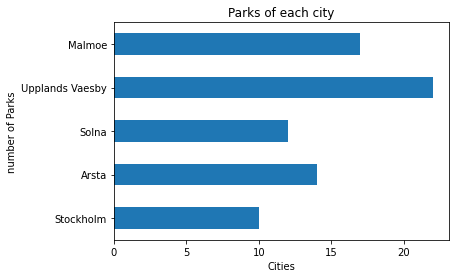

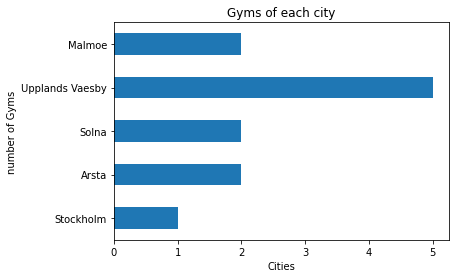

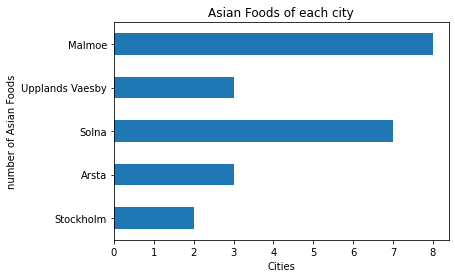

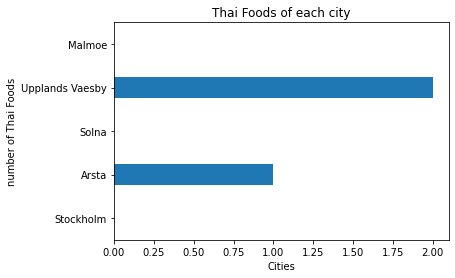

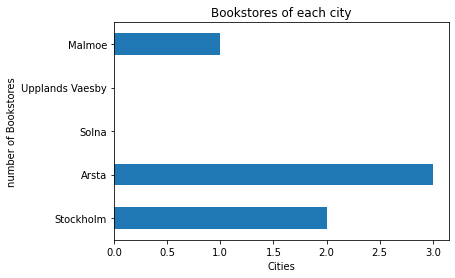

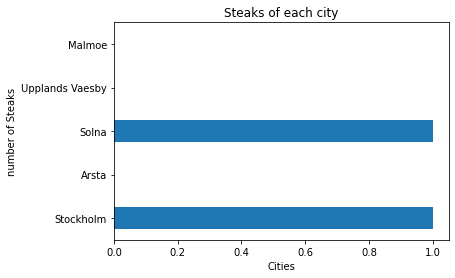

In [21]:
for col in df_city.columns:
    df_city[col].plot(kind='barh')
    plt.title(f'{col} of each city')
    plt.ylabel(f'number of {col}')
    plt.xlabel('Cities')
    plt.show()

In [27]:
# export the df for future use
df_city.to_csv('df_city.csv')

## problem

The vanue count seems quite smaller than expected. Upon examining json file I found that the json returned from the API only contains 100 venues despite me passing 200 as limit parameter. I suspect there could be a lot more vanues getting cut off.

So I will try a different approach. According to API documentation, we can query specific category. That may give me more complete result

Categories are available here  https://developer.foursquare.com/docs/build-with-foursquare/categories/

I want to scrape it and picked the ID of the ones I am interested in.



In [4]:
import pandas as pd
df_city = pd.read_csv('df_city.csv', index_col='City')
df_city

,Parks,Gyms,Asian Foods,Thai Foods,Bookstores,Steaks
City,,,,,,
Stockholm,10,1,2,0,2,1
Arsta,14,2,3,1,3,0
Solna,12,2,7,0,0,1
Upplands Vaesby,22,5,3,2,0,0
Malmoe,17,2,8,0,1,0


In [5]:
from selenium import webdriver

driver = webdriver.Firefox(executable_path='geckodriver.exe')
driver.get('https://developer.foursquare.com/docs/build-with-foursquare/categories')

In [6]:
# These are the categoeis I am interested in.
# This will be used as column order for my data frame too
interests = [
    'Park', 'Aquarium', 'Zoo', # places to visit with kids
    'Asian Restaurant', 'Steakhouse', # preferred eatery
    'Pool', 'Tennis Court', 'Skating Rink', 'Gymnastics Gym', 'Stables',  # family activity
    'Arts & Crafts Store', 'Bookstore', 'Museum', 'Buddhist Temple', # hobbies and interests
]

In [7]:
# icon img is an element I could use as starting point
icons = driver.find_elements_by_xpath('//img[contains(@src, "/categories")]')
cat_id = {}
for i in icons:
    div = i.find_element_by_xpath('..')
    cat = div.find_element_by_tag_name('h3').text
    if cat in interests:
        cat_id[cat] = div.find_element_by_tag_name('p').text
cat_id

{'Aquarium': '4fceea171983d5d06c3e9823',
 'Museum': '4bf58dd8d48988d181941735',
 'Zoo': '4bf58dd8d48988d17b941735',
 'Asian Restaurant': '4bf58dd8d48988d142941735',
 'Steakhouse': '4bf58dd8d48988d1cc941735',
 'Gymnastics Gym': '52f2ab2ebcbc57f1066b8b48',
 'Skating Rink': '4bf58dd8d48988d168941735',
 'Tennis Court': '4e39a956bd410d7aed40cbc3',
 'Park': '4bf58dd8d48988d163941735',
 'Pool': '4bf58dd8d48988d15e941735',
 'Stables': '4eb1baf03b7b2c5b1d4306ca',
 'Buddhist Temple': '52e81612bcbc57f1066b7a3e',
 'Arts & Crafts Store': '4bf58dd8d48988d127951735',
 'Bookstore': '4bf58dd8d48988d114951735'}

Note for the URL request

query = f'https://api.foursquare.com/v2/venues/explore?&client_id={ID}&client_secret={SECRET}&near={city},Sweden&radius={radius}&limit=200&v={VERSION}&categoryId={cat_id}'



In [34]:
import requests
import json

# Removing all columns from df_city
df_city = df_city.filter([])

total = {}
for cat, id in cat_id.items():
    if cat not in total:
        total[cat] = []
    for city in df_city.index:
        radius = 2000 if city in ['Stockholm', 'Arsta', 'Solna'] else 5000
        query = f'https://api.foursquare.com/v2/venues/explore?&client_id={ID}&client_secret={SECRET}&near={city},Sweden&radius={radius}&limit=200&v={VERSION}&categoryId={id}'
        # print(query)
        # print(city, cat, id)
        results = requests.get(query).json()
        count = len(results['response']['groups'][0]['items'])
        print(f'there are {count} {cat}s in {city}')
        total[cat].append(count)


there are 4 Aquariums in Stockholm
there are 3 Aquariums in Arsta
there are 2 Aquariums in Solna
there are 0 Aquariums in Upplands Vaesby
there are 4 Aquariums in Malmoe
there are 47 Museums in Stockholm
there are 57 Museums in Arsta
there are 48 Museums in Solna
there are 7 Museums in Upplands Vaesby
there are 10 Museums in Malmoe
there are 7 Zoos in Stockholm
there are 7 Zoos in Arsta
there are 1 Zoos in Solna
there are 0 Zoos in Upplands Vaesby
there are 1 Zoos in Malmoe
there are 100 Asian Restaurants in Stockholm
there are 77 Asian Restaurants in Arsta
there are 53 Asian Restaurants in Solna
there are 6 Asian Restaurants in Upplands Vaesby
there are 100 Asian Restaurants in Malmoe
there are 22 Steakhouses in Stockholm
there are 27 Steakhouses in Arsta
there are 26 Steakhouses in Solna
there are 15 Steakhouses in Upplands Vaesby
there are 20 Steakhouses in Malmoe
there are 6 Gymnastics Gyms in Stockholm
there are 6 Gymnastics Gyms in Arsta
there are 6 Gymnastics Gyms in Solna
there

In [37]:
for k, v in total.items():
    df_city[k] = v
df_city


,Aquarium,Museum,Zoo,Asian Restaurant,Steakhouse,Gymnastics Gym,Skating Rink,Tennis Court,Park,Pool,Stables,Buddhist Temple,Arts & Crafts Store,Bookstore
City,,,,,,,,,,,,,,
Stockholm,4,47,7,100,22,6,7,10,83,19,8,1,29,34
Arsta,3,57,7,77,27,6,8,10,29,18,6,1,5,6
Solna,2,48,1,53,26,6,7,9,11,20,7,1,4,43
Upplands Vaesby,0,7,0,6,15,3,5,7,14,7,5,0,10,14
Malmoe,4,10,1,100,20,1,4,5,44,8,5,1,9,9


Vanue returned still limited to 100 max but that should be good enough to make our decision.

In [38]:
df_city.to_csv('new_venue_counts.csv')

In [89]:
import pandas as pd

df_city = pd.read_csv('new_venue_counts.csv')

In [92]:
# notmalize it to make the graph looks nicer

for col in df_city.columns:
    if col == 'City':
        continue
    df_city[col] = df_city[col] / df_city[col].max()

df_city

,City,Aquarium,Museum,Zoo,Asian Restaurant,Steakhouse,Gymnastics Gym,Skating Rink,Tennis Court,Park,Pool,Stables,Buddhist Temple,Arts & Crafts Store,Bookstore
0,Stockholm,1.00,0.824561,1.000000,1.00,0.814815,1.000000,0.875,1.0,1.000000,0.95,1.000,1.0,1.000000,0.790698
1,Arsta,0.75,1.000000,1.000000,0.77,1.000000,1.000000,1.000,1.0,0.349398,0.90,0.750,1.0,0.172414,0.139535
2,Solna,0.50,0.842105,0.142857,0.53,0.962963,1.000000,0.875,0.9,0.132530,1.00,0.875,1.0,0.137931,1.000000
3,Upplands Vaesby,0.00,0.122807,0.000000,0.06,0.555556,0.500000,0.625,0.7,0.168675,0.35,0.625,0.0,0.344828,0.325581
4,Malmoe,1.00,0.175439,0.142857,1.00,0.740741,0.166667,0.500,0.5,0.530120,0.40,0.625,1.0,0.310345,0.209302


In [93]:
df_city.set_index('City')


,Aquarium,Museum,Zoo,Asian Restaurant,Steakhouse,Gymnastics Gym,Skating Rink,Tennis Court,Park,Pool,Stables,Buddhist Temple,Arts & Crafts Store,Bookstore
City,,,,,,,,,,,,,,
Stockholm,1.00,0.824561,1.000000,1.00,0.814815,1.000000,0.875,1.0,1.000000,0.95,1.000,1.0,1.000000,0.790698
Arsta,0.75,1.000000,1.000000,0.77,1.000000,1.000000,1.000,1.0,0.349398,0.90,0.750,1.0,0.172414,0.139535
Solna,0.50,0.842105,0.142857,0.53,0.962963,1.000000,0.875,0.9,0.132530,1.00,0.875,1.0,0.137931,1.000000
Upplands Vaesby,0.00,0.122807,0.000000,0.06,0.555556,0.500000,0.625,0.7,0.168675,0.35,0.625,0.0,0.344828,0.325581
Malmoe,1.00,0.175439,0.142857,1.00,0.740741,0.166667,0.500,0.5,0.530120,0.40,0.625,1.0,0.310345,0.209302


In [94]:
df_trans = df_city.transpose()
df_trans.columns = df_trans.iloc[0]
df_trans.drop(df_trans.index[0], inplace=True)
df_trans

City,Stockholm,Arsta,Solna,Upplands Vaesby,Malmoe
Aquarium,1,0.75,0.5,0,1
Museum,0.824561,1,0.842105,0.122807,0.175439
Zoo,1,1,0.142857,0,0.142857
Asian Restaurant,1,0.77,0.53,0.06,1
Steakhouse,0.814815,1,0.962963,0.555556,0.740741
Gymnastics Gym,1,1,1,0.5,0.166667
Skating Rink,0.875,1,0.875,0.625,0.5
Tennis Court,1,1,0.9,0.7,0.5
Park,1,0.349398,0.13253,0.168675,0.53012
Pool,0.95,0.9,1,0.35,0.4


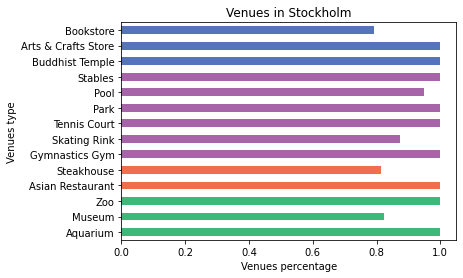

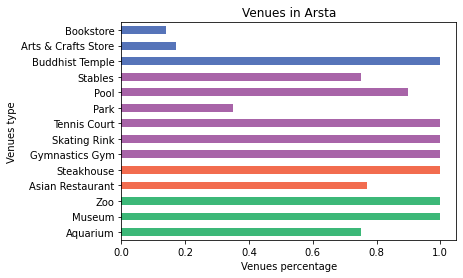

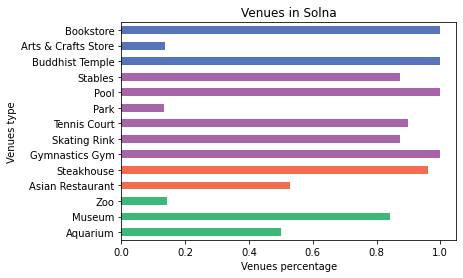

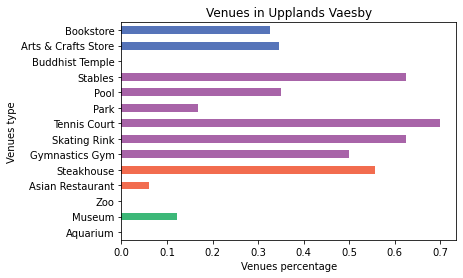

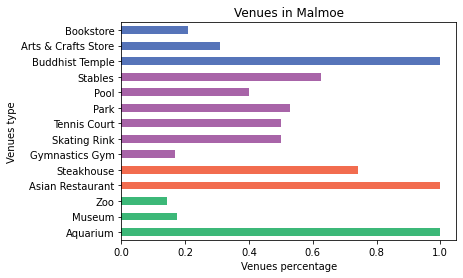

In [96]:
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

color = ['#5674b9']*3
color += ['#a864a8']*6
color += ['#f26c4f']*2
color += ['#3cb878']*3
color.reverse()

for col in df_trans.columns:
    df_trans[col].plot(kind='barh', color=color)
    plt.title(f'Venues in {col}')
    plt.ylabel('Venues type')
    plt.xlabel('Venues percentage')
    plt.show()